<br>


<div align="left">Implemented by: Mekie Ralph Kevin</div>
<div align="left">Period : 03/2025</div><br><br><br>

<div align="center">
  <span style="font-family:Lucida Calligraphy; font-size:30px;">
    Projet de finance
  </span>
</div>
<br><br>
<hr>


<br>

<div align="center">
    <span style=" font-size:32px; color: #00008B;">
        Extension de la courbe Euribor 6M à partir des données de marché
    </span>
</div><br>
<hr>

<div align="center" style="border-bottom:solid #00008B">
    <h1>Introduction et présentation des données</h1>
</div>

<div align="left" style="border-bottom:solid #1E90FF; width: 50%;">
    <h3> Problématique et présentation des données</h3>
</div>

##### Courbe Euribor 6M 

La courbe Euribor 6M est une courbe chaque point sur l'axe des abscisses représente un instant futur où l’on observe  le taux Euribor 6 mois.
Par exemple, si un point de la courbe a une abscisse de 5 ans et une ordonnée de 2,5%, cela signifie que dans 5 ans, le marché anticipe un taux Euribor 6 mois de 2,5%. \
Cela signifie qu’un investisseur s’attend à ce que dans 5 ans, une banque puisse emprunter à un taux Euribor 6 mois de 2,5%. \
\
\
Plusieurs raisons peuvent motiver la recherche d'une courbe Euribor. Prenons l'exemple d'une obligation flottante dont les coupons sont indexés sur le taux Euribor 6M : l'analyse d'un tel instrument financier nécessite l'utilisation de taux Euribor 6M à des instants futurs. Cela soulève ainsi la problématique de ce sujet, qui porte sur l'extension de la courbe Euribor 6M.


##### Base OIS

Pour ce projet, d'une part nous disposons, d'une base de données contenant les taux sans risque (taux OIS) pour différentes maturités. Plus précisément, nous avons : 
* Les taux OIS pour des maturités allant de 1 jour à 18 mois. (Deposit)
* Les cotations en taux des Swap OIS pour des maturités de 2 ans à 30 ans.
  
Cette base nous permettra ainsi de déterminer nos coefficients d'actualisation à partir du taux sans risque.

##### Base Euribor

D'autre part, nous disposons d'une base de données comprenant:
* Taux Euribor au comptant (Deposit) : \
  Pour les maturités très courtes (1 jour à 6 mois),les taux Euribor observés sur le marché interbancaire.
* Taux futures sur Euribor : \
  Pour les maturités intermédiaires (6 mois à 18 mois), les FRA (OTC) ou futures cotés sur les marchés financiers (du fait de leur caractère collatéralisé, les futures ne nécéssitent pas d'ajustement de convexité contrairement aux FRA).
* Swaps de taux Euribor : \
  Pour les maturités plus longues (2 ans à 30 ans).


Nous utiliserons la notation suivante dans la suite de ce paragraphe pour les facteurs d'actualisation :

$
P(t,T) = e^{-z(t,T) \cdot \tau(t,T)} \approx \frac{1}{1 + z(t,T) \cdot \tau(t,T)}
$

où : 
* $ z(t,T) $ est le taux d'actualisation annualisé de référence connu en $ t $ pour la maturité $ T $ (généralement l'OIS dans ce qui suit). 
* $ \tau(t,T) $ est la fraction de jour entre $ t $ et $ T $ (qui dépend de la convention de comptage des jours). \

Nous distinguerons également les trade dates et les spot dates, qui correspondent aux trade dates plus 2 jours ouvrés.


<div align="left" style="border-bottom: 3px solid #1E90FF; width: 50%;">
    <h3> Import des packages, modules et choix des paramètres</h3>
</div>

**Import des packages**

In [313]:
import sys
import os
import pandas as pd
import numpy as np
import datetime as dt
import dateutil as dtu
import matplotlib.pyplot as plt

**Import des modules**

In [315]:
ProjectDir = r"C:\Users\DELL\anaconda_projects\Projet finalisé\MulticurveFrameWork_20250326"
os.chdir(ProjectDir)
import SpecialInterpols as Interps #Importer le module nécésaire à l'interpolation cubique
#import ForwardCurve_functions as fnct # Importer les différentes fonctions 

**Import des données**

In [317]:
DataDir = "\\".join([ProjectDir,'Data'])
Ois_Raw_DF = pd.read_csv(DataDir+"\\Ois_Inputs.csv", sep=',')
Euribor_Raw_DF = pd.read_csv(DataDir+"\\Euribor_Inputs.csv", sep=',')

In [318]:
Ois_Raw_DF.T

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
ID,2,3,4,5,6,7,8,9,10,11,...,15,16,17,18,19,20,21,22,23,24
Type,Depo,Depo,Depo,Depo,Depo,Depo,Depo,Depo,Depo,Swap,...,Swap,Swap,Swap,Swap,Swap,Swap,Swap,Swap,Swap,Swap
Tenor,1D,1W,1M,2M,3M,6M,9M,1Y,18M,2Y,...,6Y,7Y,8Y,9Y,10Y,12Y,15Y,20Y,25Y,30Y
Rates,-0.0047,-0.0046,-0.0046,-0.0047,-0.0047,-0.0048,-0.005,-0.0051,-0.0052,-0.0053,...,-0.0047,-0.0044,-0.004,-0.0036,-0.0032,-0.0023,-0.0013,-0.0004,-0.0004,-0.0007


**Parametres de dates**

In [320]:
start_date_char = "30/06/2020"

computation_date = dt.datetime.strptime(start_date_char,"%d/%m/%Y")
stl_period_days = 2
spot_date = dt.timedelta(days=stl_period_days) + computation_date

<div align="center" style="border-bottom:solid  #000080">
<h1> 1 - Calcul des coefficients d'actualisation sur taux sans risque</h1>
</div>

Après la crise de 2007, les taux Overnight sont devenus les taux sans risque, au détriment des taux Euribor. De ce fait, l'actualisation se fait principalement avec le taux OIS. Ainsi, cette première partie portera sur le calcul des facteurs d'actualisation à l'aide du taux Overnight.

<div align="left" style="border-bottom: 3px solid #1E90FF; width: 50%;">
    <h3>1.1 - Méthodologie de calcul des coefficients d'actualisation sur le taux sans risque</h3>
</div>

<div align="left" style="border-bottom: 3px solid #87CEFA; width: 25%;">
    <h5>1.1.1 - Théorie de construction </h5>
</div>



**L'équation du NPV du swap en fonction du taux fixe est donnée par :**

$$ NPV_{swap}(K) = 
\sum_{i=1}^n \tau(t_{i-1}, t_i) \cdot P(spotdate, t_i) \cdot F(spotdate, t_{i-1}, t_i)  
- \sum_{i=1}^n \tau(t_{i-1}, t_i) \cdot P(spotdate, t_i) \cdot K $$

**On a :**

$P(t_{i-1}, t_i) = \frac{1}{1 + \tau(t_{i-1}, t_i) \cdot F(spotdate, t_{i-1}, t_i)}$

**D'où :**

$$\tau(t_{i-1}, t_i) \cdot F(spotdate, t_{i-1}, t_i) = \frac{1}{P(t_{i-1}, t_i)} - 1 \tag{1}$$

**De plus, on a :**

$$P(spotdate, t_i) = P(spotdate, t_{i-1}) \cdot P(t_{i-1}, t_i) \tag{2}$$

**D'où :**

$\sum_{i=1}^n \tau(t_{i-1}, t_i) \cdot F(spotdate, t_{i-1}, t_i) \cdot P(spotdate, t_i)$

$= \sum_{i=1}^n \left( \frac{P(spotdate, t_i)}{P(t_{i-1}, t_i)} - P(spotdate, t_i) \right) \quad \textbf{(d'après (1))}$

$= \sum_{i=1}^n \left( P(spotdate, t_{i-1}) - P(spotdate, t_i) \right) \quad \textbf{(d'après (2))}$

$= P(spotdate, t_0) - P(spotdate, t_n)$

$= 1 - P(spotdate, t_n)$



**Ainsi, on obtient :**

$ NPV_{swap}(K) = 
\sum_{i=1}^n \tau(t_{i-1}, t_i) \cdot P(spotdate, t_i) \cdot F(spotdate, t_{i-1}, t_i)  - \sum_{i=1}^n \tau(t_{i-1}, t_i) \cdot P(spotdate, t_i) \cdot K
 $
  
$NPV_{swap}(K) = 
1 - P(spotdate, t_n) - \sum_{i=1}^n \tau(t_{i-1}, t_i) \cdot P(spotdate, t_i) \cdot K$

**Comme on a pour tout $ n $ :**

$NPV_{swap}(SwapRate(T_n)) = 0$

**Alors :**

$1 - P(spotdate, T_n) = \sum_{i=1}^n \tau(t_{i-1}, t_i) \cdot P(spotdate, t_i) \cdot SwapRate(T_n)$

**D'où les formules finales :**

$P(spotdate, T_n) = 1 - SwapRate(T_n) \sum_{i=1}^{n} \tau(t_{i-1}, t_i) \cdot P(spotdate, t_i)$

$$P(spotdate, T_n) = \frac{1 - SwapRate(T_n) \sum_{i=1}^{n-1} \tau(t_{i-1}, t_i) \cdot P(spotdate, t_i)}{1 + SwapRate(T_n) \cdot \tau(t_{n-1}, t_n)}$$


<div align="left" style="border-bottom: 3px solid #87CEFA;; width: 25%;">
    <h5>1.1.2 - Algorithme de Construction </h5>
</div>


La courbe des taux zéro-coupon est basée sur le principe selon lequel tous les instruments appartenant à cette courbe ont une valeur nulle s'ils sont évalués sur celle-ci.



1. **Interpolation par spline cubique des taux de swap OIS**, en utilisant la périodicité de la jambe fixe (6M pour l'Euribor en général). Cela permet d'obtenir les taux de swap pour chaque point de périodicité en utilisant les données de marché disponibles.

2. **Calcul des facteurs d'actualisation pour le court et moyen terme** (jusqu'à 21 mois pour les Depo), obtenus à partir des cotations du marché des dépôts via la formule :

   $$
   P(\text{spotdate}, T) = \frac{1}{1 + \text{quote}(T) \cdot \tau(\text{spotdate},T)}
   $$

3. **Calcul des facteurs d'actualisation à partir de 2 ans**, en utilisant les taux de swap obtenus à l'étape 1 et en résolvant la formule de parité suivante :

   $$
   P(\text{spotdate}, T_n) = \frac{1 - \text{SwapRate}(T_n) \sum_{i=1}^{n-1} \tau(t_{i-1}, t_i) P(\text{spotdate}, t_i)}{1 + \text{SwapRate}(T_n) \cdot \tau(t_{n-1}, t_n)}
   $$

4. **Application répétée pour chaque maturité** $T_n $ disponible sur les cotations de swaps OIS. En utilisant tous les facteurs d'actualisation $ P(t_0,t_i) $ pour $ i \in (1, \dots, n-1) $, on obtient $ P(t_0, t_n) $.


<div align="left" style="border-bottom: 3px solid #1E90FF; width: 50%;">
    <h3>1.2 - Calcul des coefficients d'actualisation sur le taux sans risque</h3>
</div>

<div align="left" style="border-bottom: 3px solid #87CEFA;; width: 25%;">
    <h5>1.2.1 - Partie Déposit</h5>
</div>

A l'aide une fonction nous ajoutons les parametres de dates où alpha c'est $ \tau(spotdate,adjdate) $

In [333]:
#limite des DEPO
ois_depo_limit = '2Y'

#Fréquence de d'échange du SWAP
ois_swap_freq = 1

goal_seek_ois_DF = Ois_Raw_DF.copy()

In [334]:
goal_seek_ois_DF = fnct.add_dates(goal_seek_ois_DF, computation_date, spot_date, convention = "ACT/360")
goal_seek_ois_DF.head()

,ID,Type,Tenor,Rates,cmpt_date,spot_date,unadj_date,adj_date,day_diff,convention,alpha
0,2,Depo,1D,-0.0047,2020-06-30,2020-07-02,2020-07-03,2020-07-03,1,ACT/360,0.002778
1,3,Depo,1W,-0.0046,2020-06-30,2020-07-02,2020-07-09,2020-07-09,7,ACT/360,0.019444
2,4,Depo,1M,-0.0046,2020-06-30,2020-07-02,2020-08-02,2020-08-03,32,ACT/360,0.088889
3,5,Depo,2M,-0.0047,2020-06-30,2020-07-02,2020-09-02,2020-09-02,62,ACT/360,0.172222
4,6,Depo,3M,-0.0047,2020-06-30,2020-07-02,2020-10-02,2020-10-02,92,ACT/360,0.255556


Nous trouvons les facteurs d'actualisation pour les Depo

In [336]:
goal_seek_ois_DF['discount_factor'] = goal_seek_ois_DF.apply(lambda x : [1/(1+x.Rates*x.alpha) if x.Type!='Swap' else np.nan ][0] , axis=1)

<div align="left" style="border-bottom: 3px solid #87CEFA;; width: 25%;">
    <h5>1.2.2 - Partie Swap </h5>
</div>

Nous créons un dataframe composé des branches du swap pour exécuter la 3ᵉ partie de l'algorithme

In [339]:
swap_key=(goal_seek_ois_DF.Type=='Swap')
ois_max_year = int(str.replace(goal_seek_ois_DF.loc[swap_key,:].sort_values(by='day_diff').Tenor.iloc[-1],'Y',''))
floating_leg_swap_settlements = (np.arange(0,int(ois_max_year*ois_swap_freq+1))/ois_swap_freq) # .astype(np.int64)
ois_swap_DF = pd.DataFrame({'coupons':floating_leg_swap_settlements})
print(floating_leg_swap_settlements)
print(ois_swap_DF.head())

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]
   coupons
0      0.0
1      1.0
2      2.0
3      3.0
4      4.0


In [340]:
#calcul du tenor en mois
ois_swap_DF['Tenor'] = ois_swap_DF.apply(lambda x : str(int(x.coupons*12))+'M', axis=1)
ois_swap_DF = fnct.add_dates(ois_swap_DF, computation_date, spot_date, convention = "ACT/360")
#calcul des tau(ti-1,ti)
ois_swap_DF['day_diff_shift'] =  ois_swap_DF.day_diff - ois_swap_DF.day_diff.shift(1).fillna(0)
ois_swap_DF['alpha'] = ois_swap_DF.apply(lambda x : eval(str.replace(x.convention,'ACT','x.day_diff_shift')) , axis=1)
ois_swap_DF.drop(columns='Tenor', inplace=True)
ois_swap_DF = ois_swap_DF[ois_swap_DF.coupons>0]
#merge entre ces deux dataframe par daydiff pour rajouter les taux swap ainsi que les discount-factor
ois_swap_DF = ois_swap_DF.merge(goal_seek_ois_DF[['day_diff', 'Rates', 'discount_factor']], how='left', on='day_diff')
#interpolation par splines cubiques pour avoir les différents taux swap pour chaque année
ois_swap_DF['splined_swap_rates'] = Interps.SplineCubique(goal_seek_ois_DF.day_diff, goal_seek_ois_DF.Rates, ois_swap_DF.day_diff).y.values
ois_swap_DF.head()

,coupons,cmpt_date,spot_date,unadj_date,adj_date,day_diff,convention,alpha,day_diff_shift,Rates,discount_factor,splined_swap_rates
0,1.0,2020-06-30,2020-07-02,2021-07-02,2021-07-02,365,ACT/360,1.013889,365.0,-0.0051,1.005198,-0.0051
1,2.0,2020-06-30,2020-07-02,2022-07-02,2022-07-04,732,ACT/360,1.019444,367.0,-0.0053,NaN,-0.0053
2,3.0,2020-06-30,2020-07-02,2023-07-02,2023-07-03,1096,ACT/360,1.011111,364.0,-0.0053,NaN,-0.0053
3,4.0,2020-06-30,2020-07-02,2024-07-02,2024-07-02,1461,ACT/360,1.013889,365.0,-0.0052,NaN,-0.0052
4,5.0,2020-06-30,2020-07-02,2025-07-02,2025-07-02,1826,ACT/360,1.013889,365.0,-0.0050,NaN,-0.0050


Calcul des discount factors par la formule de l’étape 3 de l'algorithme, en sachant que le premier discount factor correspond au dépo 12 mois, et que les suivants seront calculés par la formule décrite à la 4ᵉ étape de l’algorithme.

In [342]:
for c in floating_leg_swap_settlements[1:]:
    ois_swap_line = ois_swap_DF[ois_swap_DF.coupons==c].copy()
    if np.isnan(ois_swap_line.discount_factor).values[0]:
        print('CashFlow N°'+str(c*ois_swap_freq)+' --  DF computation. \n')
        temp_ois_swap = ois_swap_DF[ np.where(ois_swap_DF.day_diff < ois_swap_line.day_diff.values[0],True,False)]
        temp_ois_swap.insert(loc=temp_ois_swap.shape[1]-1, column='pv_pc_i', value=temp_ois_swap.apply(lambda x : x.alpha * x.discount_factor, axis=1))
        ois_swap_line.loc[:,'pv_pc'] = temp_ois_swap.pv_pc_i.sum()
        ois_swap_line.loc[:, 'discount_factor'] = ois_swap_line.apply(lambda x : (1 - x.splined_swap_rates * x.pv_pc) / (1 + x.alpha * x.splined_swap_rates), axis=1)
        ois_swap_DF.loc[ois_swap_DF.coupons==c, 'discount_factor'] = ois_swap_line.loc[:, 'discount_factor']
        

goal_seek_ois_DF.loc[swap_key,'discount_factor'] = Interps.SplineCubique(ois_swap_DF.day_diff, ois_swap_DF.discount_factor, goal_seek_ois_DF.loc[swap_key,:].day_diff).y.values


CashFlow N°2.0 --  DF computation. 

CashFlow N°3.0 --  DF computation. 

CashFlow N°4.0 --  DF computation. 

CashFlow N°5.0 --  DF computation. 

CashFlow N°6.0 --  DF computation. 

CashFlow N°7.0 --  DF computation. 

CashFlow N°8.0 --  DF computation. 

CashFlow N°9.0 --  DF computation. 

CashFlow N°10.0 --  DF computation. 

CashFlow N°11.0 --  DF computation. 

CashFlow N°12.0 --  DF computation. 

CashFlow N°13.0 --  DF computation. 

CashFlow N°14.0 --  DF computation. 

CashFlow N°15.0 --  DF computation. 

CashFlow N°16.0 --  DF computation. 

CashFlow N°17.0 --  DF computation. 

CashFlow N°18.0 --  DF computation. 

CashFlow N°19.0 --  DF computation. 

CashFlow N°20.0 --  DF computation. 

CashFlow N°21.0 --  DF computation. 

CashFlow N°22.0 --  DF computation. 

CashFlow N°23.0 --  DF computation. 

CashFlow N°24.0 --  DF computation. 

CashFlow N°25.0 --  DF computation. 

CashFlow N°26.0 --  DF computation. 

CashFlow N°27.0 --  DF computation. 

CashFlow N°28.0 --  

In [343]:
#goal_seek_ois_DF.discount_factor

<div align="left" style="border-bottom: 3px solid #1E90FF; width: 50%;">
    <h3>1.3 - Resultat</h3>
</div>

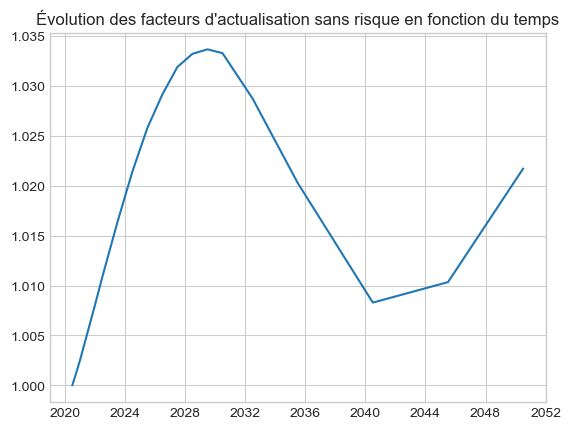

In [345]:
plt.plot(pd.to_datetime(goal_seek_ois_DF["adj_date"]), goal_seek_ois_DF["discount_factor"], label="Raw Euribor 6M Forward rates"); 

plt.title("Évolution des facteurs d'actualisation sans risque en fonction du temps")
plt.show()


<div align="center" style="border-bottom:solid #000080">
<h1> 2 - Calcul des taux Euribor 6M</h1>
</div>

In [347]:
eur_depo_limit = '7M'
#Fréquence de la jambe variable de swap
eur_swap_freq = 2
goal_seek_eurib_DF = Euribor_Raw_DF.copy()

<div align="left" style="border-bottom: 3px solid #1E90FF; width: 50%;">
    <h3>2.1 - Méthodologie de calcul des taux euribors</h3>
</div>

<div align="left" style="border-bottom: 3px solid #87CEFA;; width: 25%;">
    <h5>2.1.1 - Instruments Requis </h5>
</div>



- **Court terme** (≤6 mois) : Depo
  
- **Moyen terme** (7-21 mois) : FRA sur euribor (interpolation spline cubique)

- **Long terme** (≥2 ans) : Taux swaps sur euribor (dont la jambe fixe est à fréquence annuelle et la jambe variable à fréquence semestrielle avec respectivement une convenation ...)

$ NPV_{swap}(K) = 
\sum_{i=1}^n \tau(t_{i-1}, t_i) \cdot P(spotdate, t_i) \cdot F(spotdate, t_{i-1}, t_i)  - \sum_{i=1}^n \tau(t_{i-1}, t_i) \cdot P(spotdate, t_i) \cdot K
 $
   
$$
\begin{aligned}
& NPV_{swap}(SwapRate(T_n)) = 0 \\
& \iff \sum_{i=1}^n \tau(t_{i-1}, t_i) P(spotdate, t_i) F(spotdate, t_{i-1}, t_i) = \sum_{i=1}^n \tau(t_{i-1}, t_i) P(spotdate, t_i) SwapRate(T_n) \\
& \iff F(spotdate, t_{n-1}, t_n) = \frac{
    \sum_{i=1}^n \tau(t_{i-1}, t_i) P(spotdate, t_i) SwapRate(T_n) - \sum_{i=1}^{n-1} \tau(t_{i-1}, t_i) P(spotdate, t_i) F(spotdate, t_{i-1}, t_i)
}{
    \tau(t_{n-1}, t_n) P(spotdate, t_n)
}
\end{aligned}
$$

<div align="left" style="border-bottom: 3px solid #87CEFA;; width: 25%;">
    <h5>2.1.2 - Algorithme de Construction </h5>
</div>


1. **Calcul des facteurs d'actualisation avec les taux depo :**
    $
   P_{depo}(spotdate,T)=\frac{1}{1 + quote(T) \cdot \tau(spotdate,T)}
   $
2. **Interpolation FRA spline cubique mensuelle** pour avoir les taux FRA des tous les tenors
3. **Calcul des discounts factors moyen terme** :  
    $
    P(spotdate,T) = P_{depo}(spotdate,T-6M) \cdot \frac{1}{1 + \tau(T-6M,T)*FRA(T-6M,T)}
    $
4. **Interpolation des taux swaps** sur en utilisant la periodicité de la branche variable (6 mois)
5. Calcul des taux Forward
 \
$$
 F(spotdate, t_{n-1}, t_n) = \frac{
    \sum_{i=1}^n \tau(t_{i-1}, t_i) P(spotdate, t_i) SwapRate(T_n) - \sum_{i=1}^{n-1} \tau(t_{i-1}, t_i) P(spotdate, t_i) F(spotdate, t_{i-1}, t_i)
}{
    \tau(t_{n-1}, t_n) P(spotdate, t_n)
}
$$
**Remarque:** Les facteurs d'actualisation $(P)$ viennent de la courbe OIS, tandis que les taux forwards $(F)$ et le Swaprate sont basés sur l'Euribor. Contrairement au cas de la partie 1, on ne peut pas simplifier cette expréssion car ces éléments car ils proviennent de courbes différentes.

6. **Calcul des discount factors sur euribor 6M pour des maturité superieures ou égales à 2Y** \
   $$
\frac{P(t_{i-1}, t_{i})}{P(t_{i}, t_{i+1})} = \prod_{j=1}^{N} \left(1 + F(t_j, t_j + \theta) \cdot \tau(t_{j-1}, t_j)\right)
$$

**où:**
- $ N = \frac{\text{Fixed Leg Periodicity}}{\text{Floating Leg Periodicity}} $
- **Example (Euribor 6M):**
  - fréquence jambe fixe = 1Y
  - fréquence jemebe variable = 6M
  - donc \( N = \frac{1}{0.5} = 2 \)
7. Ayant tous les discounts factor sur euribor de la jambe variable du swap (à frequence 6 mois) $P_{swap}(t_{i-1},t_i)$ où $ t_i - t_{i-1} = 0,5Y$
on à 
$$P_{swap}(t_{i-1},t_i)=\frac{1}{(1 + tauxEuribor(t_{i-1}))^{tau(t_{i-1},t_i)}}$$  
Ainsi $$ tauxEuribor(t_{i-1}) = \frac{1}{P_{swap}(t_{i-1},t_i)}^{\frac{-1}{tau(t_{i-1},t_i)}} - 1 $$

<div align="left" style="border-bottom: 3px solid #1E90FF; width: 50%;">
    <h3>2.2 - Calcul des taux euribors</h3>
</div>

<div align="left" style="border-bottom: 3px solid #87CEFA;; width: 25%;">
    <h5>2.2.1 - Déposit et Futures</h5>
</div>

In [355]:
goal_seek_eurib_DF.Rates /=100
goal_seek_eurib_DF = fnct.add_dates(goal_seek_eurib_DF, computation_date, spot_date, convention = "ACT/360")
#1ère étape de l'algorithme
goal_seek_eurib_DF['discount_factor'] = goal_seek_eurib_DF.apply(lambda x : [1/(1+x.Rates*x.alpha) if x.Type!='Swap' else np.nan ][0] , axis=1)

In [356]:
goal_seek_eurib_DF.head()

,ID,Type,Tenor,Rates,cmpt_date,spot_date,unadj_date,adj_date,day_diff,convention,alpha,discount_factor
0,2,Depo,1D,-0.00470,2020-06-30,2020-07-02,2020-07-03,2020-07-03,1,ACT/360,0.002778,1.000013
1,3,Depo,1W,-0.00518,2020-06-30,2020-07-02,2020-07-09,2020-07-09,7,ACT/360,0.019444,1.000101
2,4,Depo,1M,-0.00510,2020-06-30,2020-07-02,2020-08-02,2020-08-03,32,ACT/360,0.088889,1.000454
3,5,Depo,2M,-0.00466,2020-06-30,2020-07-02,2020-09-02,2020-09-02,62,ACT/360,0.172222,1.000803
4,6,Depo,3M,-0.00422,2020-06-30,2020-07-02,2020-10-02,2020-10-02,92,ACT/360,0.255556,1.001080


**Nous allons passer aux prochaines étapes sachant que les FRA ont pour convention ACT/360 et les depo ACT/365**

In [358]:
# Traitement des FRA
FRA_Key = goal_seek_eurib_DF.Type.str.upper().isin(['FRA', 'FUT'])
Eur_6M_Rate = goal_seek_eurib_DF.query("Tenor=='6M'").Rates.values[0]
goal_seek_eurib_DF['convention_zero_rate'] = "ACT/365"; goal_seek_eurib_DF['Fra_Depo_AccPer'] = np.nan
#calcul de la différence de jour entre spotdate et T-M pour chaque tenor T
goal_seek_eurib_DF.loc[FRA_Key ,'Fra_Depo_AccPer'] = goal_seek_eurib_DF[FRA_Key].apply(lambda x : (fnct.adjust_date(fnct.tenor_to_date(x.spot_date, x.Tenor) - dtu.relativedelta.relativedelta(months=6)) - x.cmpt_date).days , axis=1 )
#calcul de la différence de jour entre T-M et T  pour chaque tenor T
goal_seek_eurib_DF.loc[FRA_Key ,'Fra_ExpiToMatur_AccPer'] = goal_seek_eurib_DF[FRA_Key].apply(lambda x : -(fnct.adjust_date(fnct.tenor_to_date(x.spot_date, x.Tenor) - dtu.relativedelta.relativedelta(months=6)) - x.adj_date).days , axis=1 )
#Calcul des discount factor
goal_seek_eurib_DF.loc[FRA_Key ,'discount_factor'] = goal_seek_eurib_DF[FRA_Key].apply(lambda x : np.exp(- Eur_6M_Rate  * eval(str.replace(x.convention_zero_rate,'ACT','x.Fra_Depo_AccPer'))) * 1/(1+x.Rates*eval(str.replace(x.convention,'ACT','x.Fra_ExpiToMatur_AccPer'))) , axis=1)
eurib_fra_max_daydiff = goal_seek_eurib_DF.loc[FRA_Key,:].sort_values(by='day_diff').day_diff.iloc[-1]

<div align="left" style="border-bottom: 3px solid #87CEFA;; width: 25%;">
    <h5>2.2.2 - Partie Swap</h5>
</div>

**Nous allons passer au traitement des SWAP, sachant que la jambe variable à une fréquence semestrielle, la jambe fixe annuelle et q'uil y a echange de flux à une fréquence annuelle**

In [361]:
swap_key_eurib=(goal_seek_eurib_DF.Type=='Swap')
#min des daydiff
eurib_swap_min_daydiff = goal_seek_eurib_DF.loc[swap_key_eurib,:].sort_values(by='day_diff').day_diff.iloc[0]
#max des années
eurib_max_year = int(str.replace(goal_seek_eurib_DF.loc[swap_key_eurib,:].sort_values(by='day_diff').Tenor.iloc[-1],'Y',''))
#coupon du swap
floating_leg_swap_stl_eurib = (np.arange(0,int(eurib_max_year*eur_swap_freq+1))/eur_swap_freq) # .astype(np.int64)
eur_swap_DF = pd.DataFrame({'coupons':floating_leg_swap_stl_eurib})
eur_swap_DF.head()

,coupons
0,0.0
1,0.5
2,1.0
3,1.5
4,2.0


In [362]:
#calcul des différents tenor en mois
eur_swap_DF['Tenor'] = eur_swap_DF.apply(lambda x : str(int(x.coupons*12))+'M', axis=1)
#ajouts des dates
eur_swap_DF = fnct.add_dates(eur_swap_DF, computation_date, spot_date, convention = "ACT/360")

#calcul des alpha flotteurs, les alapha fixes sont déjà calculé dans la fonction précédente
eur_swap_DF['day_diff_flt'] =  eur_swap_DF.day_diff - eur_swap_DF.day_diff.shift(1).fillna(0)
eur_swap_DF['alpha_flt'] = eur_swap_DF.apply(lambda x : eval(str.replace(x.convention,'ACT','x.day_diff_flt')) , axis=1)

eur_swap_DF.drop(columns='Tenor', inplace=True)
eur_swap_DF = eur_swap_DF[eur_swap_DF.coupons>0]
#interpolation des discount factor sans risque pour avoir ceux des tenors de la jambe variable
eur_swap_DF['ois_discount'] = Interps.SplineCubique(goal_seek_ois_DF.day_diff, goal_seek_ois_DF.discount_factor, eur_swap_DF.day_diff).y.values
eur_swap_DF = eur_swap_DF.merge(goal_seek_eurib_DF[['day_diff', 'Rates', 'discount_factor']], how='left', on='day_diff')
#les tenors de 0;5 à 1.5 correspondent aux FRA dont on possède (6M, 1ans,1.5ans)
eur_swap_DF

,coupons,cmpt_date,spot_date,unadj_date,adj_date,day_diff,convention,alpha,day_diff_flt,alpha_flt,ois_discount,Rates,discount_factor
0,0.5,2020-06-30,2020-07-02,2021-01-02,2021-01-04,186,ACT/360,0.516667,186.0,0.516667,1.002486,-0.003080,1.001594
1,1.0,2020-06-30,2020-07-02,2021-07-02,2021-07-02,365,ACT/360,1.013889,179.0,0.497222,1.005198,-0.003970,1.003569
2,1.5,2020-06-30,2020-07-02,2022-01-02,2022-01-03,550,ACT/360,1.527778,185.0,0.513889,1.008008,-0.004160,1.005251
3,2.0,2020-06-30,2020-07-02,2022-07-02,2022-07-04,732,ACT/360,2.033333,182.0,0.505556,1.010863,-0.003882,NaN
4,2.5,2020-06-30,2020-07-02,2023-01-02,2023-01-02,914,ACT/360,2.538889,182.0,0.505556,1.013638,NaN,NaN
5,3.0,2020-06-30,2020-07-02,2023-07-02,2023-07-03,1096,ACT/360,3.044444,182.0,0.505556,1.016310,-0.003905,NaN
6,3.5,2020-06-30,2020-07-02,2024-01-02,2024-01-02,1279,ACT/360,3.552778,183.0,0.508333,1.018913,NaN,NaN
7,4.0,2020-06-30,2020-07-02,2024-07-02,2024-07-02,1461,ACT/360,4.058333,182.0,0.505556,1.021387,-0.003766,NaN
8,4.5,2020-06-30,2020-07-02,2025-01-02,2025-01-02,1645,ACT/360,4.569444,184.0,0.511111,1.023718,NaN,NaN
9,5.0,2020-06-30,2020-07-02,2025-07-02,2025-07-02,1826,ACT/360,5.072222,181.0,0.502778,1.025764,-0.003525,NaN


Etape 5 de l'algorithme : calcul des taux Forward

In [364]:
#initialisation des taux forward au taux fra pour les tenors 0.5 1 et 1.5
eur_swap_DF['fwrd_rate'] = eur_swap_DF['Rates'];  eur_swap_DF.loc[eur_swap_DF.day_diff>eurib_fra_max_daydiff,'fwrd_rate']=np.nan
#interpolation des taux swap pour avoir celle des maturités de la jambe variable
eur_swap_DF['splined_swap_rates'] = Interps.SplineCubique(goal_seek_eurib_DF.day_diff, goal_seek_eurib_DF.Rates, eur_swap_DF.day_diff).y.values
#Pour des tenors correspondant au fra (0.5 1 et 1.5) ne pas mettre de taux swap
eur_swap_DF.loc[eur_swap_DF.day_diff<eurib_swap_min_daydiff, 'splined_swap_rates'] = np.nan
#pour la jambe fixe ne considérer que des tenors entiers (0 si tenor décimal) et pour la variable prendre toutes les maturités
eur_swap_DF['flt_leg_cf'] = 1
eur_swap_DF['fix_leg_cf'] = eur_swap_DF.apply(lambda x : [1 if (x.coupons-int(x.coupons)==0) else 0][0] , axis=1)

**calcul des $\tau(t_{n-1}, t_n) P(spotdate, t_n)$ pour toutes les tenors de chaque branche (et 0 si tenor décimal pour la brache fixe). \
Les $\tau(t_{n-1}, t_n)$ valent tous 1 pour la branche fixe.**

In [366]:
eur_swap_DF['unit_pv_flt'] = eur_swap_DF['flt_leg_cf'] * eur_swap_DF['ois_discount'] * eur_swap_DF['alpha_flt']
eur_swap_DF['unit_pv_fix'] = eur_swap_DF['fix_leg_cf'] * eur_swap_DF['ois_discount'] # not needed eur_swap_DF['alpha_fix'] as the rate is already annual for that special year -> alpha = 1


**Calcul des Taux Forward**

In [368]:
for c in floating_leg_swap_stl_eurib[1:]:
    eur_swap_line = eur_swap_DF[eur_swap_DF.coupons==c].copy()
    if np.isnan(eur_swap_line.fwrd_rate).values[0]:
        print('CashFlow N°'+str(c*ois_swap_freq)+' --  FW rate computation. \n')
        temp_eur_swap = eur_swap_DF[ np.where(eur_swap_DF.day_diff < eur_swap_line.day_diff.values[0],True,False)]
        temp_eur_swap.insert(loc=temp_eur_swap.shape[1]-1, column='pv_pc_flt_i', value=temp_eur_swap.apply(lambda x : x.unit_pv_flt * x.fwrd_rate, axis=1))
        temp_eur_swap.insert(loc=temp_eur_swap.shape[1]-1, column='pv_pc_fix_i', value=temp_eur_swap.apply(lambda x : x.unit_pv_fix * eur_swap_line.splined_swap_rates, axis=1))
        eur_swap_line.loc[:,'pv_pc_flt'] = temp_eur_swap.pv_pc_flt_i.sum()
        eur_swap_line.loc[:,'pv_pc_fix'] = temp_eur_swap.pv_pc_fix_i.sum()
        eur_swap_line.loc[:, 'fwrd_rate'] = eur_swap_line.apply(lambda x : ( ( x.pv_pc_fix + x.unit_pv_fix * x.splined_swap_rates ) - x.pv_pc_flt) / (x.unit_pv_flt), axis=1)
        eur_swap_DF.loc[eur_swap_DF.coupons==c, 'fwrd_rate'] = eur_swap_line.loc[:, 'fwrd_rate']

CashFlow N°2.0 --  FW rate computation. 

CashFlow N°2.5 --  FW rate computation. 

CashFlow N°3.0 --  FW rate computation. 

CashFlow N°3.5 --  FW rate computation. 

CashFlow N°4.0 --  FW rate computation. 

CashFlow N°4.5 --  FW rate computation. 

CashFlow N°5.0 --  FW rate computation. 

CashFlow N°5.5 --  FW rate computation. 

CashFlow N°6.0 --  FW rate computation. 

CashFlow N°6.5 --  FW rate computation. 

CashFlow N°7.0 --  FW rate computation. 

CashFlow N°7.5 --  FW rate computation. 

CashFlow N°8.0 --  FW rate computation. 

CashFlow N°8.5 --  FW rate computation. 

CashFlow N°9.0 --  FW rate computation. 

CashFlow N°9.5 --  FW rate computation. 

CashFlow N°10.0 --  FW rate computation. 

CashFlow N°10.5 --  FW rate computation. 

CashFlow N°11.0 --  FW rate computation. 

CashFlow N°11.5 --  FW rate computation. 

CashFlow N°12.0 --  FW rate computation. 

CashFlow N°12.5 --  FW rate computation. 

CashFlow N°13.0 --  FW rate computation. 

CashFlow N°13.5 --  FW rate

**Taux Forward en fonction des dates de fin**

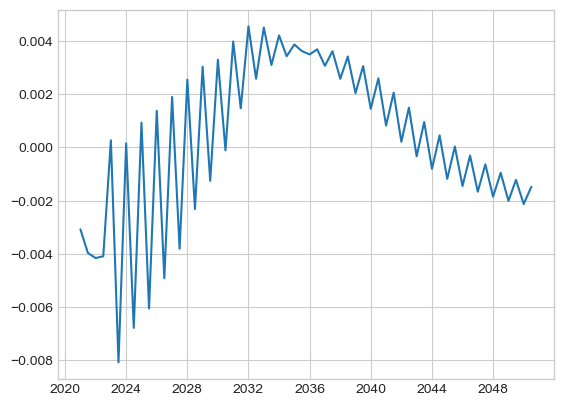

In [370]:
import matplotlib.pyplot as plt
plt.plot(pd.to_datetime(eur_swap_DF.adj_date.values), eur_swap_DF.fwrd_rate, label="Raw Euribor 6M Forward rates"); 
plt.xlabel="Dates"; plt.ylabel="ForwwradRate_Eur6M"
plt.show()


**Interpollation des forward à tenors entier par spline cubique** (dans le but de lisser les taux Forward)

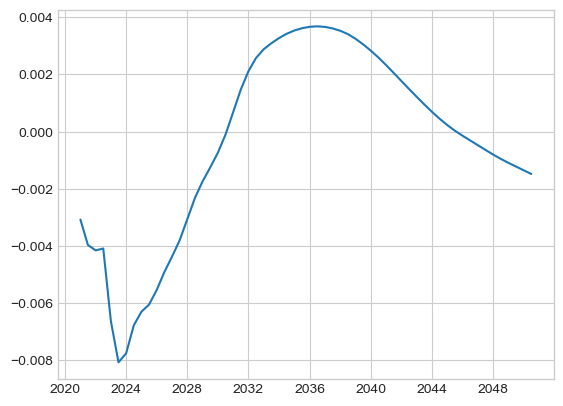

In [372]:
mask1=eur_swap_DF.day_diff>=eurib_swap_min_daydiff
mask2=(eur_swap_DF.day_diff>=eurib_swap_min_daydiff)&(eur_swap_DF.fix_leg_cf==1)
eur_swap_DF.loc[mask1,'fwrd_rate_s'] = Interps.SplineCubique(eur_swap_DF.loc[mask2,'day_diff'], eur_swap_DF.loc[mask2,'fwrd_rate'], eur_swap_DF.loc[mask1,'day_diff'],).y.values

eur_swap_DF["fwrd_rate_s"] = eur_swap_DF["fwrd_rate_s"].where(
    eur_swap_DF["fwrd_rate_s"].notna(), eur_swap_DF["fwrd_rate"]
)
## Get Euribor Discount from 2Y using already obtained forward rates
import matplotlib.pyplot as plt
plt.plot(pd.to_datetime(eur_swap_DF.adj_date.values), eur_swap_DF.fwrd_rate_s, label="Raw Euribor 6M Forward rates"); 
plt.xlabel="Dates"; plt.ylabel="ForwwradRate_Eur6M"
plt.show()

<div align="left" style="border-bottom: 3px  solid #87CEFA;; width: 25%;">
    <h5>2.2.3 - Discount Factor Euribor</h5>
</div>

**Calcul des discount factors sur euribor 6M pour des maturité superieures ou égales à 2Y**

In [375]:
eur_df_derivation = eur_swap_DF[['coupons', 'adj_date',  'day_diff', 'discount_factor', 'alpha', 'alpha_flt', 'unit_pv_flt', 'unit_pv_fix',"Rates","splined_swap_rates","fwrd_rate_s", 'fwrd_rate', 'flt_leg_cf', 'fix_leg_cf']].copy()
#alpha en t-1
eur_df_derivation['alpha_flt_L1'] = eur_df_derivation['alpha_flt'].shift(1).fillna(0)
#alpha en t-2
eur_df_derivation['alpha_flt_L2'] = eur_df_derivation['alpha_flt'].shift(2).fillna(0)
#Forward en t-1
eur_df_derivation['fwrd_rate_L1'] = eur_df_derivation['fwrd_rate'].shift(1).fillna(0)
#Forward en t-2
eur_df_derivation['fwrd_rate_L2'] = eur_df_derivation['fwrd_rate'].shift(2).fillna(0)
eur_df_derivation['swap_implied_1Y_df'] = eur_df_derivation['discount_factor']
eur_df_derivation.head()

,coupons,adj_date,day_diff,discount_factor,alpha,alpha_flt,unit_pv_flt,unit_pv_fix,Rates,splined_swap_rates,fwrd_rate_s,fwrd_rate,flt_leg_cf,fix_leg_cf,alpha_flt_L1,alpha_flt_L2,fwrd_rate_L1,fwrd_rate_L2,swap_implied_1Y_df
0,0.5,2021-01-04,186,1.001594,0.516667,0.516667,0.517951,0.000000,-0.003080,NaN,-0.003080,-0.003080,1,0,0.000000,0.000000,0.000000,0.00000,1.001594
1,1.0,2021-07-02,365,1.003569,1.013889,0.497222,0.499807,1.005198,-0.003970,NaN,-0.003970,-0.003970,1,1,0.516667,0.000000,-0.003080,0.00000,1.003569
2,1.5,2022-01-03,550,1.005251,1.527778,0.513889,0.518004,0.000000,-0.004160,NaN,-0.004160,-0.004160,1,0,0.497222,0.516667,-0.003970,-0.00308,1.005251
3,2.0,2022-07-04,732,NaN,2.033333,0.505556,0.511048,1.010863,-0.003882,-0.003882,-0.004093,-0.004093,1,1,0.513889,0.497222,-0.004160,-0.00397,NaN
4,2.5,2023-01-02,914,NaN,2.538889,0.505556,0.512450,0.000000,NaN,-0.003815,-0.006634,0.000265,1,0,0.505556,0.513889,-0.004093,-0.00416,NaN


**Calcul des disount facteurs pour les maturités de la branche fixe et interpolation pour les autres maturités**


In [377]:
for c in eur_df_derivation.coupons:
    if np.isnan(eur_df_derivation.query("coupons==@c").discount_factor).values[0]:
        tmp_df_deriv = eur_df_derivation.query("coupons<=@c").copy()
        tmp_df_deriv['DF_L1'] = tmp_df_deriv['swap_implied_1Y_df'].shift(1).fillna(0)
        tmp_df_deriv['DF_L2'] = tmp_df_deriv['swap_implied_1Y_df'].shift(2).fillna(0)
        loc_curr_cpn = (eur_df_derivation.coupons==c)
        loc_tmp_curr_cpn = (tmp_df_deriv.coupons==c); tmp_curr_cpn = tmp_df_deriv.loc[loc_tmp_curr_cpn,:].copy()
        if c==2:
            eur_df_derivation.loc[loc_curr_cpn,'swap_implied_1Y_df'] = tmp_curr_cpn.fix_leg_cf * tmp_curr_cpn.DF_L1 / (1+ tmp_curr_cpn.alpha_flt * tmp_curr_cpn.fwrd_rate)
        else:
            eur_df_derivation.loc[loc_curr_cpn,'swap_implied_1Y_df'] = tmp_curr_cpn.fix_leg_cf * tmp_curr_cpn.DF_L2 / ( (1+ tmp_curr_cpn.alpha_flt * tmp_curr_cpn.fwrd_rate) * (1+ tmp_curr_cpn.alpha_flt_L1 * tmp_curr_cpn.fwrd_rate_L1) )

#Interpolation par spline cubique pour avoir le discount factor sur toutes les maturités
eur_df_derivation.loc[eur_df_derivation.day_diff>=eurib_swap_min_daydiff,'discount_factor'] = Interps.SplineCubique(eur_df_derivation.loc[eur_df_derivation.swap_implied_1Y_df!=0,'day_diff'], eur_df_derivation.loc[eur_df_derivation.swap_implied_1Y_df!=0,'swap_implied_1Y_df'], eur_df_derivation.loc[eur_df_derivation.day_diff>=eurib_swap_min_daydiff,'day_diff']).y.values


**lissage des taux forward grace au discount factors interpollés**

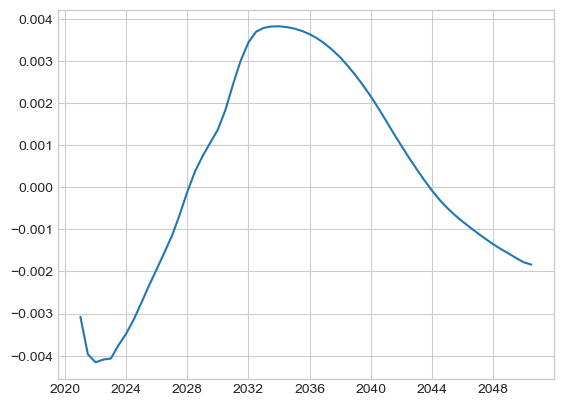

In [379]:
eur_df_derivation['refined_fwrd_rate'] = (eur_df_derivation['discount_factor'].shift(1) / eur_df_derivation['discount_factor'] - 1)/eur_df_derivation['alpha_flt']
eur_df_derivation.loc[eur_df_derivation.day_diff<eurib_swap_min_daydiff,'refined_fwrd_rate'] = eur_df_derivation.loc[eur_df_derivation.day_diff<eurib_swap_min_daydiff,'fwrd_rate']

plt.plot(pd.to_datetime(eur_df_derivation.adj_date.values), eur_df_derivation.refined_fwrd_rate, label="Refined Euribor 6M Forward rates"); 
plt.xlabel="Dates"; plt.ylabel="RefForwardRate_Eur6M"
plt.show()

**Calcul des erreur de repricing avec taux forward et les taux forward lissés (les taux swap lissés viennent d'une part du lissage obtenu par spline cubique des taux forward à tenors entier et d'autre part des discount factor interporlés qui seront utilisé pour calculer les ZC, donc cette erreur sert d'indication l'erreur d'estimation des ZC finaux)**

In [381]:
eur_df_derivation["splined_swap_rates_v2"] = eur_df_derivation["splined_swap_rates"].where(
    eur_df_derivation["splined_swap_rates"].notna(), eur_df_derivation["Rates"]
)

eur_df_derivation["splined_swap_rates_v2"].head()
#Premier lissage de taux forward
eur_df_derivation["error_fwrd_rate_V3"]= abs(eur_swap_DF["unit_pv_fix"].cumsum()*eur_df_derivation["splined_swap_rates_v2"]-(eur_df_derivation["unit_pv_flt"]*eur_df_derivation["fwrd_rate_s"]).cumsum())
#Deuxième lissage de taux forward
eur_df_derivation["error_fwrd_rate_V2"]=abs(eur_swap_DF["unit_pv_fix"].cumsum()*eur_df_derivation["splined_swap_rates_v2"]-(eur_df_derivation["unit_pv_flt"]*eur_df_derivation["refined_fwrd_rate"]).cumsum())
#Taux Forward donné par l'algorithme
eur_df_derivation["error_fwrd_rate_V1"]=abs(eur_swap_DF["unit_pv_fix"].cumsum()*eur_df_derivation["splined_swap_rates_v2"]-(eur_df_derivation["unit_pv_flt"]*eur_df_derivation["fwrd_rate"]).cumsum())

eur_df_derivation[["error_fwrd_rate_V1","error_fwrd_rate_V2","error_fwrd_rate_V3"]].head()

,error_fwrd_rate_V1,error_fwrd_rate_V2,error_fwrd_rate_V3
0,0.001595,1.595290e-03,0.001595
1,0.000411,4.111129e-04,0.000411
2,0.001553,1.552797e-03,0.001553
3,0.000000,5.204170e-18,0.000000
4,0.000000,2.221086e-03,0.003535


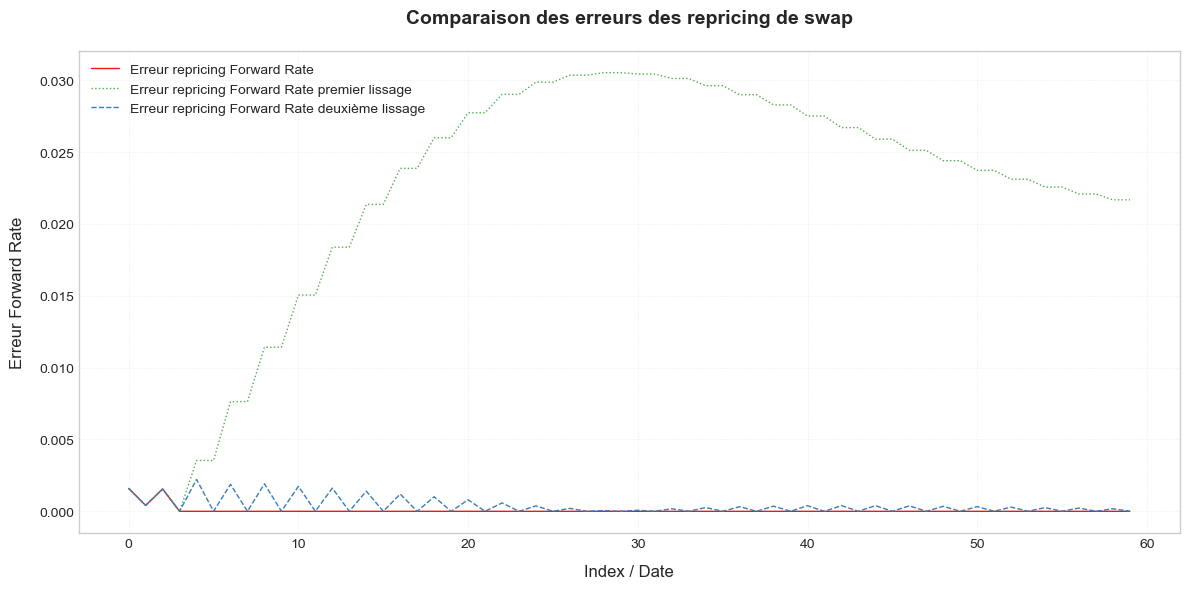

In [382]:
# Configuration du style
plt.style.use('seaborn-v0_8-whitegrid')  # Style clair avec grille légère

# Paramètres des lignes
line_width = 1.0  # Lignes fines

# Création du graphique
fig, ax = plt.subplots(figsize=(12, 6))

# Tracé des courbes sans marqueurs
ax.plot(eur_df_derivation.index, eur_df_derivation["error_fwrd_rate_V1"],
        label="Erreur repricing Forward Rate", 
        color="#E41A1C",  # Rouge
        linewidth=line_width,
        linestyle="-")  # Trait continu


ax.plot(eur_df_derivation.index, eur_df_derivation["error_fwrd_rate_V3"],
        label="Erreur repricing Forward Rate premier lissage", 
        color="#4DAF4A",  # Vert
        linewidth=line_width,
        linestyle=":")  # Pointillés

ax.plot(eur_df_derivation.index, eur_df_derivation["error_fwrd_rate_V2"],
        label="Erreur repricing Forward Rate deuxième lissage", 
        color="#377EB8",  # Bleu
        linewidth=line_width,
        linestyle="--")  # Tirets

# Personnalisation avancée
ax.set_title("Comparaison des erreurs des repricing de swap", 
             fontsize=14, pad=20, fontweight="bold")
ax.set_xlabel("Index / Date", fontsize=12, labelpad=10)
ax.set_ylabel("Erreur Forward Rate", fontsize=12, labelpad=10)

# Légende
legend = ax.legend(loc="best", fontsize=10, framealpha=1)
legend.get_frame().set_linewidth(0.5)

# Grille subtile
ax.grid(True, linestyle=":", linewidth=0.5, alpha=0.5)

# Ajustement final
plt.tight_layout()
plt.show()

**Ainsi nous predrons le deuxième lissage de taux Forward**

<div align="left" style="border-bottom: 3px solid #87CEFA;; width: 25%;">
    <h5>2.2.4 - Taux Euribor 6M</h5>
</div>

**Calcul des taux euribor**

In [386]:
eur_df_derivation['convention_zero_rate'] = "ACT/365"
eur_df_derivation['alpha_Zc_6M'] = eur_df_derivation.apply(lambda x : eval(str.replace(x.convention_zero_rate,'ACT','x.day_diff')) , axis=1)
eur_df_derivation['Zc_6M'] = eur_df_derivation.apply(lambda x : 100*(np.power(x.discount_factor,-1/x.alpha_Zc_6M) - 1)  , axis=1)

**Merge et calcul des taux euribors 6M**

In [388]:
goal_seek_eurib_DF = goal_seek_eurib_DF.rename(columns={'discount_factor':'discount_factor_init'}).merge(eur_df_derivation[['day_diff', 'fwrd_rate', 'discount_factor', 'Zc_6M', 'refined_fwrd_rate']], how='left', on='day_diff')
goal_seek_eurib_DF['discount_factor'] = goal_seek_eurib_DF['discount_factor'].fillna(goal_seek_eurib_DF['discount_factor_init'])
goal_seek_eurib_DF['convention_zero_rate'] = "ACT/365"
goal_seek_eurib_DF['alpha_Zc_6M'] = goal_seek_eurib_DF.apply(lambda x : eval(str.replace(x.convention_zero_rate,'ACT','x.day_diff')) , axis=1)
goal_seek_eurib_DF['Zc_6M'] = goal_seek_eurib_DF.apply(lambda x : 100*(np.power(x.discount_factor,-x.alpha_Zc_6M) - 1)  , axis=1)

<div align="left" style="border-bottom: 3px solid #1E90FF; width: 50%;">
    <h3>2.3 - Résultat</h3>
</div>

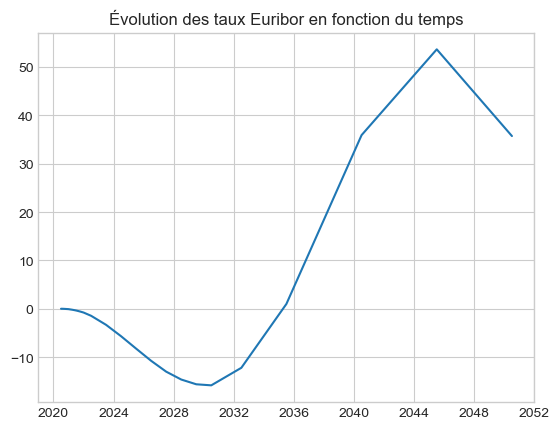

In [390]:
plt.plot(pd.to_datetime(goal_seek_eurib_DF["adj_date"]), goal_seek_eurib_DF["Zc_6M"], label="Raw Euribor 6M Forward rates"); 

plt.title("Évolution des taux Euribor en fonction du temps")
plt.show()
